# 1. Phân tích comment

In [19]:
%store -r clean_df

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from facebook_scraper import *
from geopy.geocoders import Nominatim
from langdetect import detect, LangDetectException
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from geopy.geocoders import Nominatim
from googletrans import Translator
from time import sleep

## 1.1 Ngôn ngữ trong comment

In [21]:
#THU THẬP COMMENT_TEXT
comments = []
for post in clean_df['comments_full']:
    try:
        post_clean = re.sub(r'datetime\.datetime\([^)]*\)', 'None', post)
        for comment in eval(post_clean):
            cmt_text = re.sub(r'\W+', ' ', comment['comment_text'])
            if cmt_text not in comments:
                comments.append(cmt_text)
    except ValueError as e:
        print({e})
print(len(comments))

2573


In [22]:
# HÀM XÁC ĐỊNH NGÔN NGỮ TRONG COMMENT

def lang_df(comments):
    # Tạo DataFrame từ danh sách comments
    comments_df = pd.DataFrame(comments, columns=['comment'])
    
    # Loại bỏ các comment rỗng hoặc chỉ chứa ký tự đặc biệt
    comments_df['comment'] = comments_df['comment'].str.replace(r'\W+', ' ', regex=True).str.strip()
    comments_df = comments_df[comments_df['comment'] != '']
    
    # Thêm một cột mới cho ngôn ngữ được phát hiện
    comments_df['language'] = None
    
    # Áp dụng hàm detect lên mỗi comment và xử lý ngoại lệ
    for index, row in comments_df.iterrows():
        try:
            comments_df.at[index, 'language'] = detect(row['comment'])
        except LangDetectException:
            comments_df.at[index, 'language'] = 'unknown'
    
    # Thống kê số lượng mỗi ngôn ngữ
    language_statistics = comments_df['language'].value_counts().reset_index()
    
    return language_statistics

In [23]:
language_statistics = lang_df(comments)

In [24]:
# TẠO BIỂU ĐỒ THỐNG KÊ NGÔN NGỮ ĐƯỢC SỬ DỤNG TRONG 2573 COMMENT

top_10_languages = language_statistics.sort_values(by='count', ascending=False).head(10)
top_10_languages['percentage'] = (top_10_languages['count'] / top_10_languages['count'].sum()) * 100
lang_plot = px.pie(top_10_languages, values='percentage', names='language')
lang_plot.show()

## 1.2 Quốc gia của người comment

In [25]:
cmter_df = pd.read_csv('Data/Raw_cmter_df.csv')

In [26]:
# Lấy tên thành phố từ cột "Nơi từng sống" và chuyển thành df

def process_line(line):
    # Kiểm tra xem giá trị có phải là chuỗi không
    if isinstance(line, str) and "Tỉnh/Thành phố hiện tại" in line:
        parts = line.split('\n')
        city_index = parts.index("Tỉnh/Thành phố hiện tại")
        if city_index > 0:
            return parts[city_index - 1].strip()
    return None
cmter_df['city'] = cmter_df['Nơi từng sống'].apply(process_line)

In [27]:
# Hàm tìm đất nước dựa vào thành phố

geolocator = Nominatim(user_agent="geocode_service")

def country(place):
    sleep(2)
    # Handle some special case
    if ',' in place:
        place = place.split(', ')[-1].strip()
    
    try:
        location = geolocator.geocode(place, language='en')
        if location:
            return location.address.split(',')[-1].strip()
        else:
            raise Exception("Geocode failed")
    except Exception as e:
        print("Geocode error for:", place, "| Error:", e)
        try:
            translator = Translator()
            translated_place = translator.translate(place, dest='en').text
            return country(translated_place)
        except Exception as e:
            print("Translation and geocode error for:", place, "| Error:", e)
            return None

In [28]:
# cmter_df['country'] = cmter_df['city'].apply(lambda x: country(x) if x else None)
# cmter_df['country']
# cmter_df.to_csv('Data/Handle_cmter_df.csv', index=False)

# Đã xử lý và lưu vào Handle_cmter_df.csv

In [29]:
cmter_df = pd.read_csv('Data/Handle_cmter_df.csv')

In [30]:
newDf = cmter_df['country'].value_counts().reset_index().head(10)
# # Bây giờ, bạn có thể sử dụng plotly.express để vẽ biểu đồ
fig = px.bar(newDf, x='country', y='count')
fig.show()

## 1.3 Điều các game thủ bình luận

In [31]:
len(comments)

2573

In [32]:
text = ''
for t in comments:
    text += t
    text += ' '

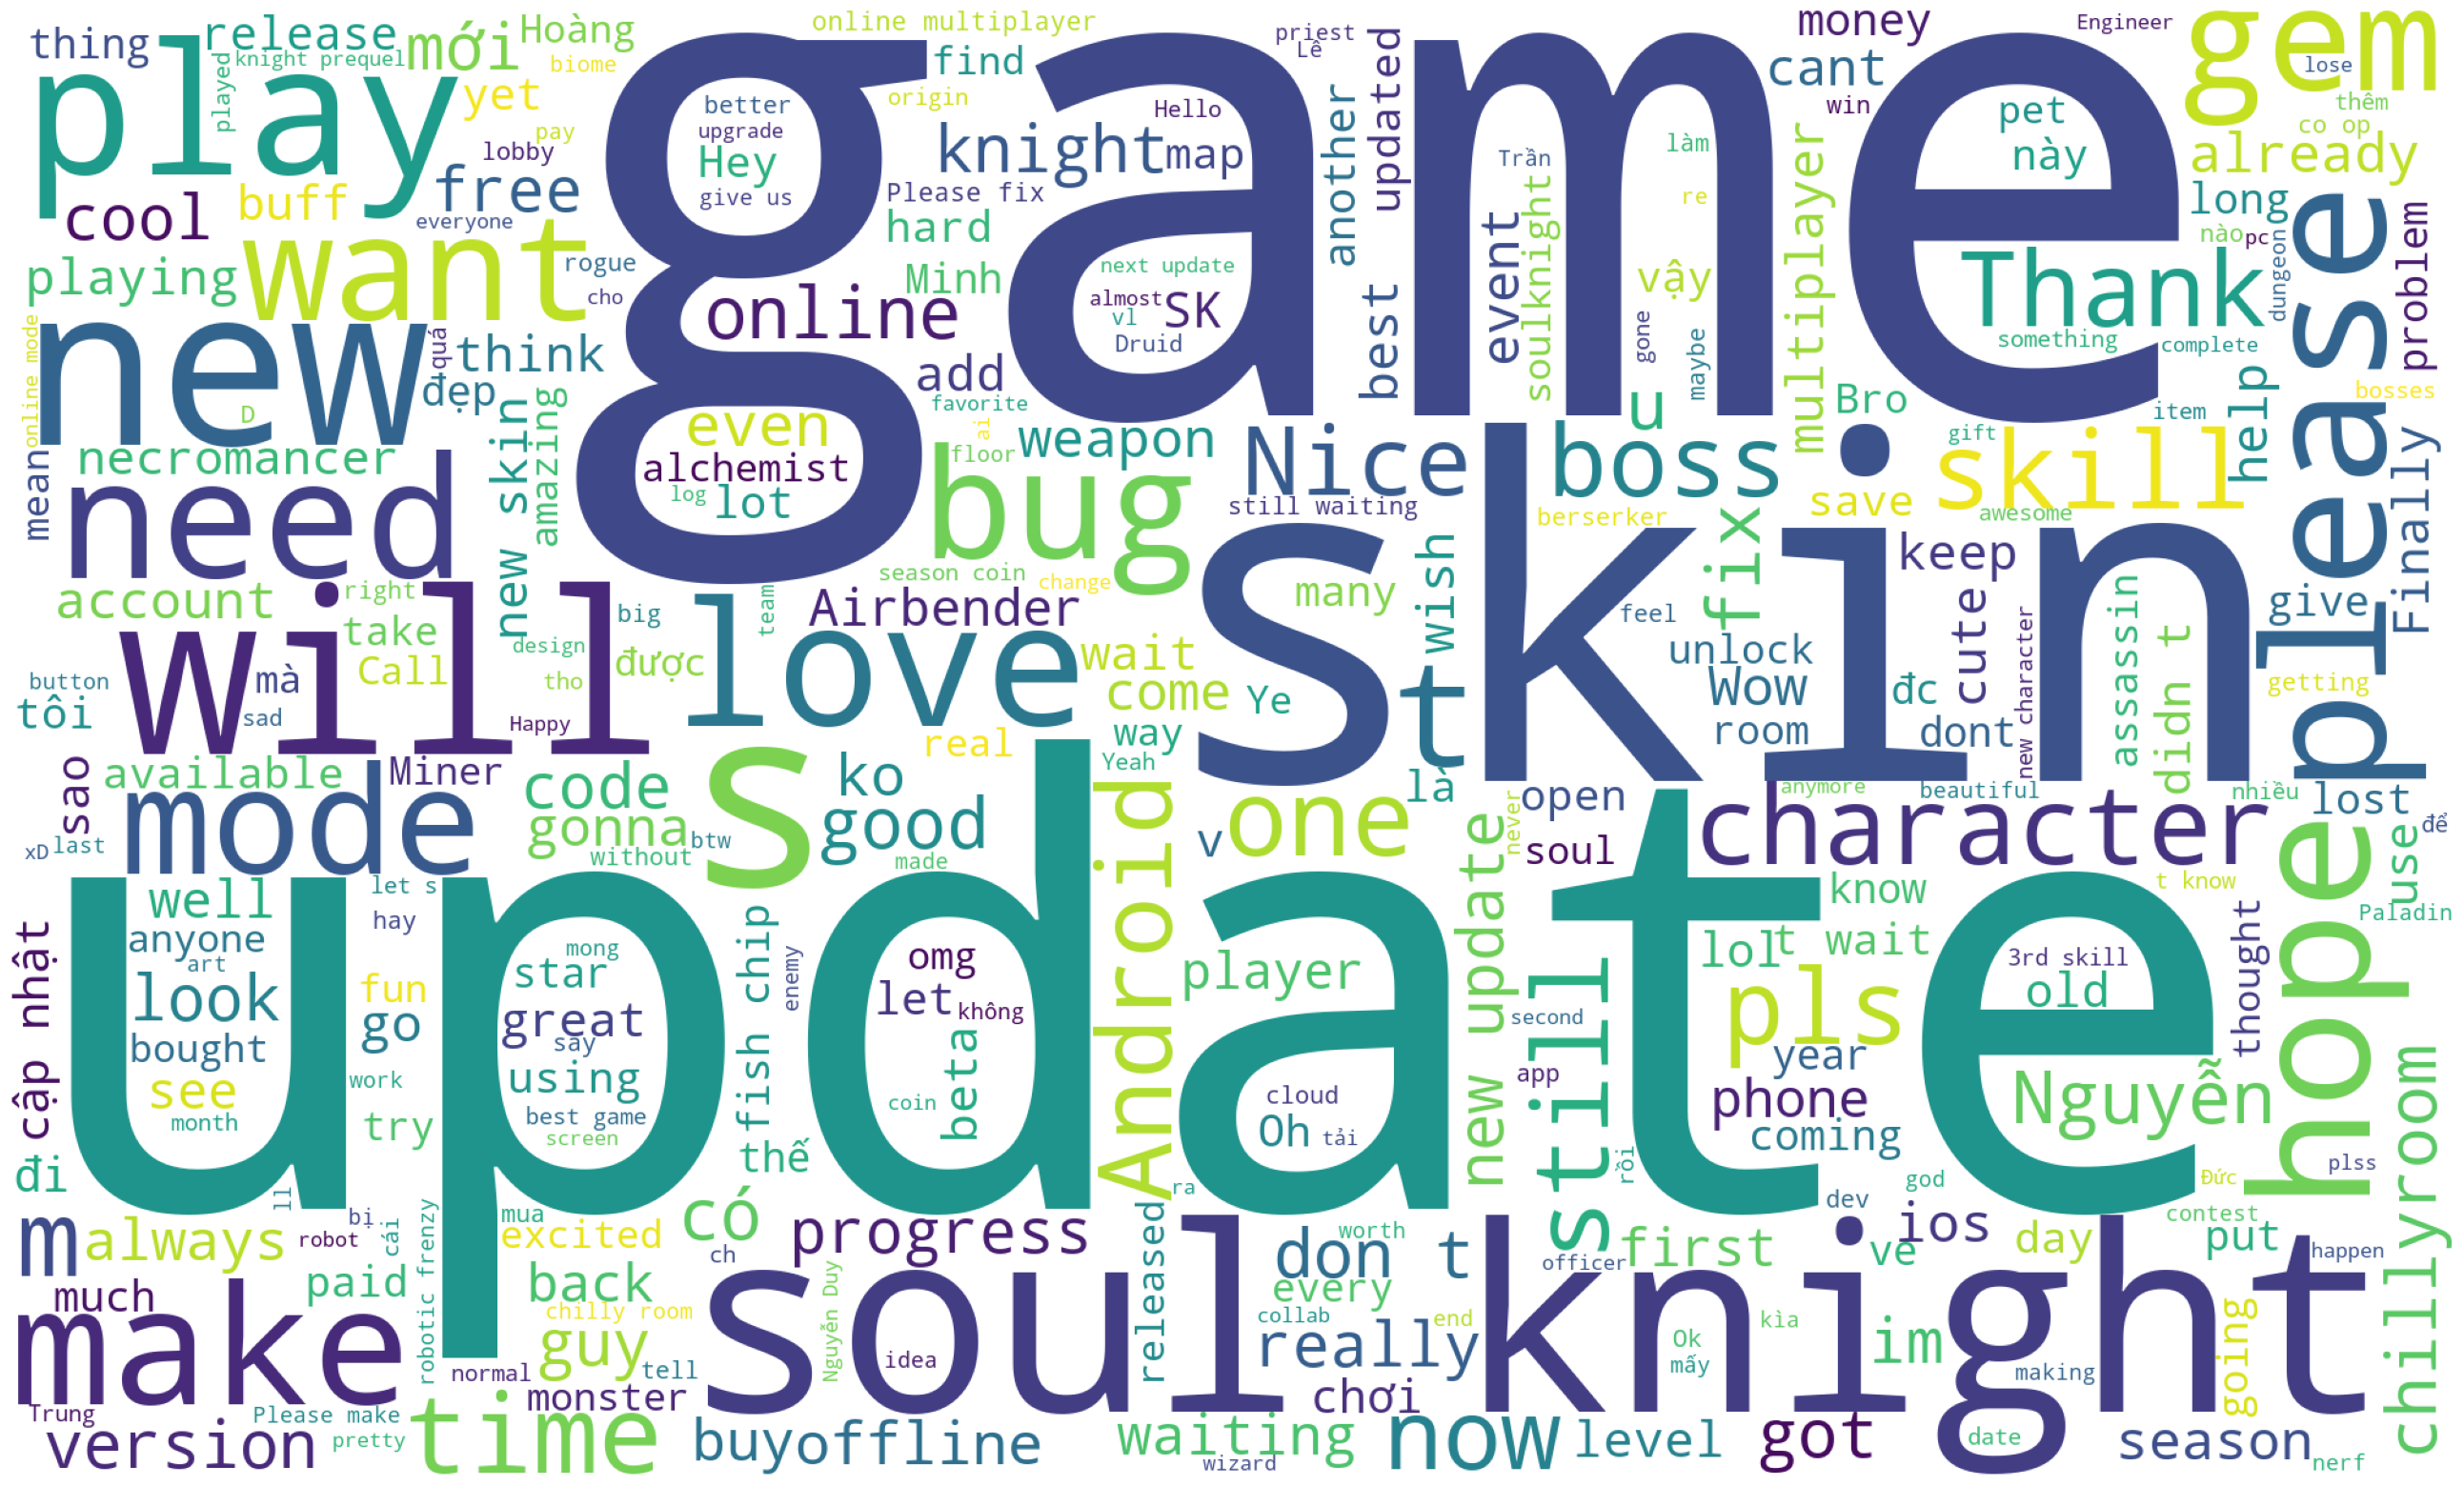

In [33]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1200
                         ).generate(text)
plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()